In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

In [4]:
BASE_DIR = "../../../tests/dataset-tests/sineasy10-10k-s05/"

# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

In [5]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

profiles= ["sineasy10-3x512-s05", "sineasy10-3x256-s05", "sineasy10-3x128-s05"]

names = [configs[p]["NAME"] for p in profiles]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(profiles))]

reruns = 1

In [6]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x7f21768fb5e0>)

In [7]:


train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

In [8]:
#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": results[name]["train"]["error"]["rmse"],
        "In domain RMSE": results[name]["in_domain"]["error"]["rmse"],
        "Out domain RMSE": results[name]["out_domain"]["error"]["rmse"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

print(table.to_markdown())
print()

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train MAE": results[name]["train"]["error"]["mae"],
        "In domain MAE": results[name]["in_domain"]["error"]["mae"],
        "Out domain MAE": results[name]["out_domain"]["error"]["mae"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

print(table.to_markdown())
print()

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train log likelihood", "In domain log likelihood", "Out domain log likelihood"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train log likelihood": results[name]["train"]["error"]["loglikelihood"],
        "In domain log likelihood": results[name]["in_domain"]["error"]["loglikelihood"],
        "Out domain log likelihood": results[name]["out_domain"]["error"]["loglikelihood"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

print(table.to_markdown())

|    | Name                |   Likelihood_std |   Train RMSE |   In domain RMSE |   Out domain RMSE |
|---:|:--------------------|-----------------:|-------------:|-----------------:|------------------:|
|  0 | sineasy10-3x512-s05 |              0.5 |     0.460043 |         0.618958 |           11.2764 |
|  1 | sineasy10-3x256-s05 |              0.5 |     0.47403  |         0.623613 |           11.4747 |
|  2 | sineasy10-3x128-s05 |              0.5 |     0.508522 |         0.648361 |           11.4582 |

|    | Name                |   Likelihood_std |   Train MAE |   In domain MAE |   Out domain MAE |
|---:|:--------------------|-----------------:|------------:|----------------:|-----------------:|
|  0 | sineasy10-3x512-s05 |              0.5 |    0.366643 |        0.493461 |          8.98306 |
|  1 | sineasy10-3x256-s05 |              0.5 |    0.377148 |        0.495881 |          9.19558 |
|  2 | sineasy10-3x128-s05 |              0.5 |    0.407108 |        0.516883 |          9.15

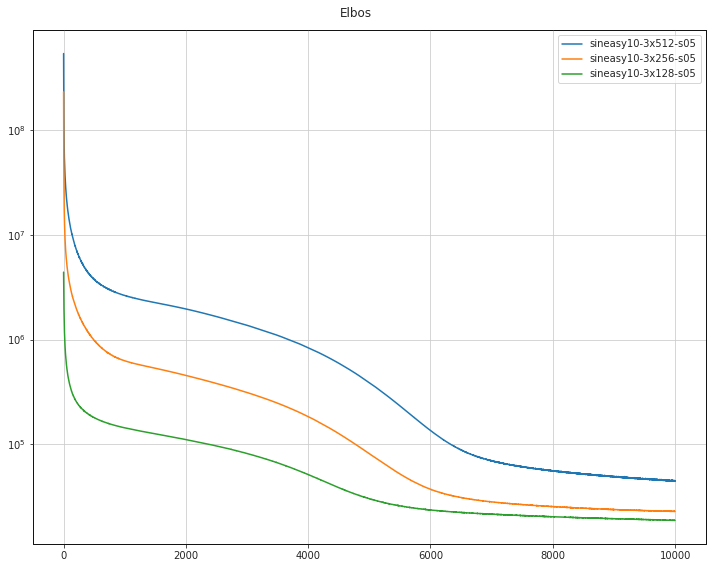

5.407096191909578
5.4514067498180605
5.370787256227599


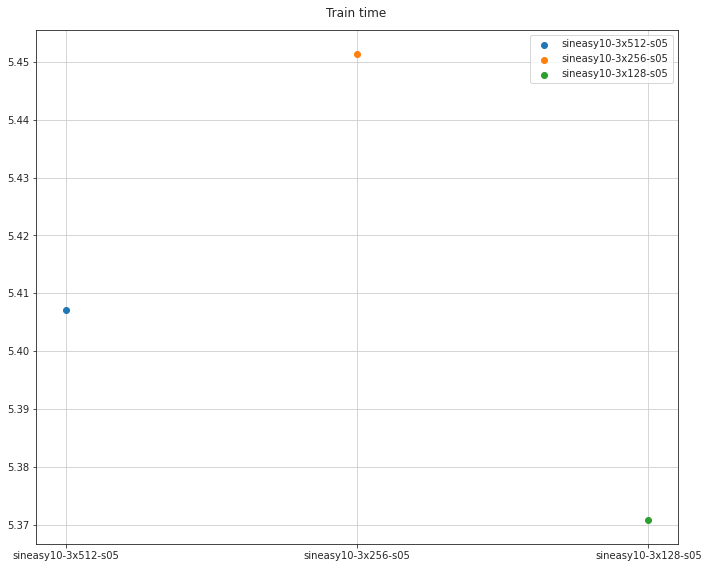

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Elbos")
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = train_stats[name]["elbos"]
    ax.plot(elbos, label=name)
ax.set_yscale("symlog", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend()
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg")
plt.show()

#plot train time
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Train time")
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    train_time = (train_stats[name]["time"])/60/60
    print(train_time)
    ax.scatter(name, train_time, label=name)
ax.legend()
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/train_time.svg", format="svg")
plt.show()


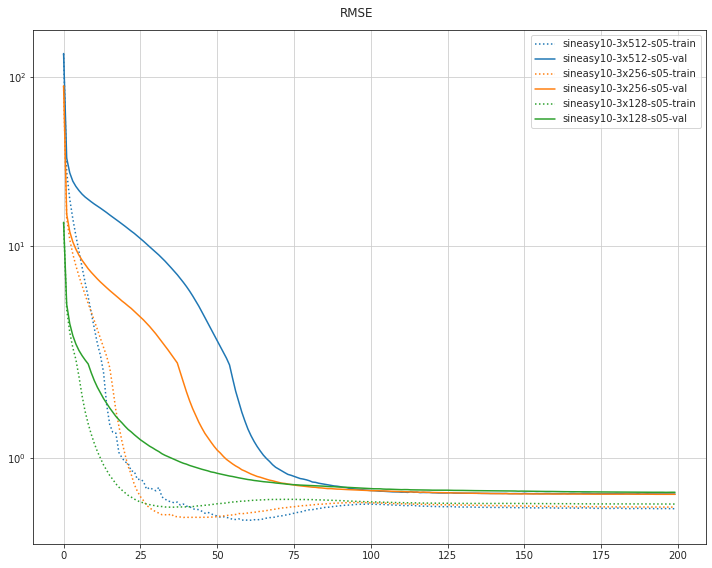

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("RMSE")
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = train_stats[name]["train_rmse"]
    ax.plot(te, ':', label=f"{name}-train", color=colors[i])
    ve = train_stats[name]["val_rmse"]
    ax.plot(ve, label=f"{name}-val", color=colors[i])
    ax.set_yscale('symlog', base=10)
ax.legend()
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse.svg", format="svg")
plt.show()

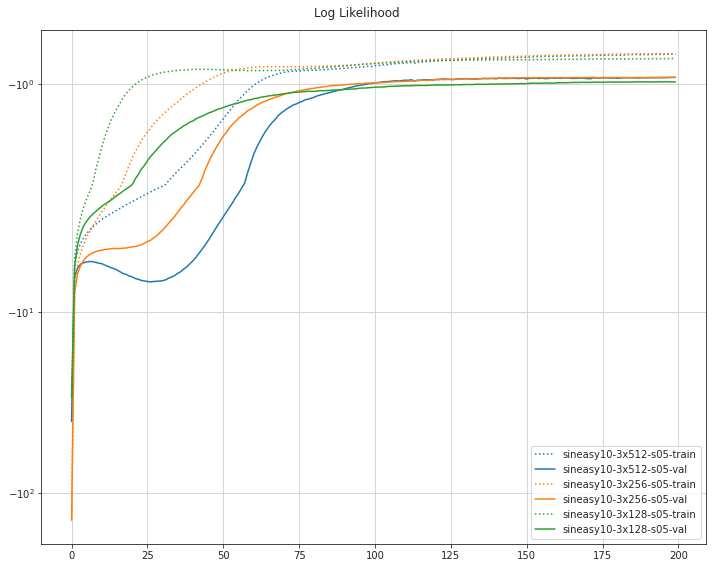

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Log Likelihood")
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    tll = train_stats[name]["train_ll"]
    ax.plot(tll, ':', label=f"{name}-train", color=colors[i])
    vll = train_stats[name]["val_ll"]
    ax.plot(vll, label=f"{name}-val", color=colors[i])
    ax.set_yscale('symlog', base=10)
plt.tight_layout()
ax.legend()
plt.show()

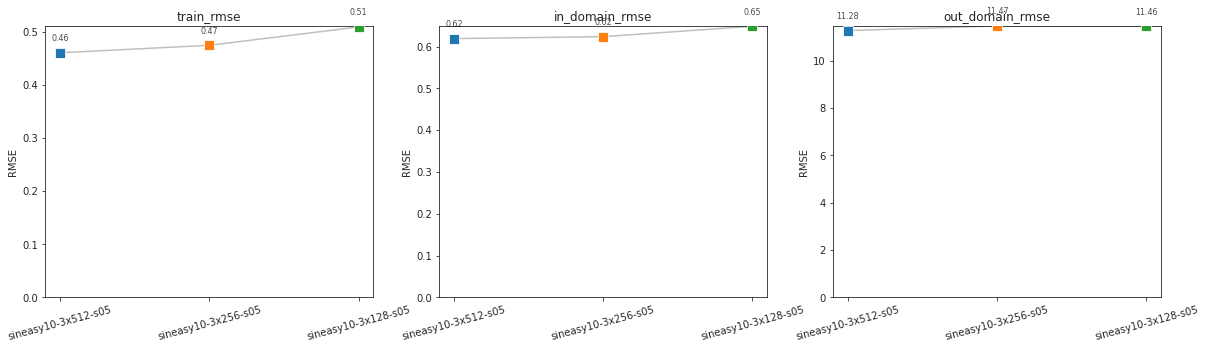

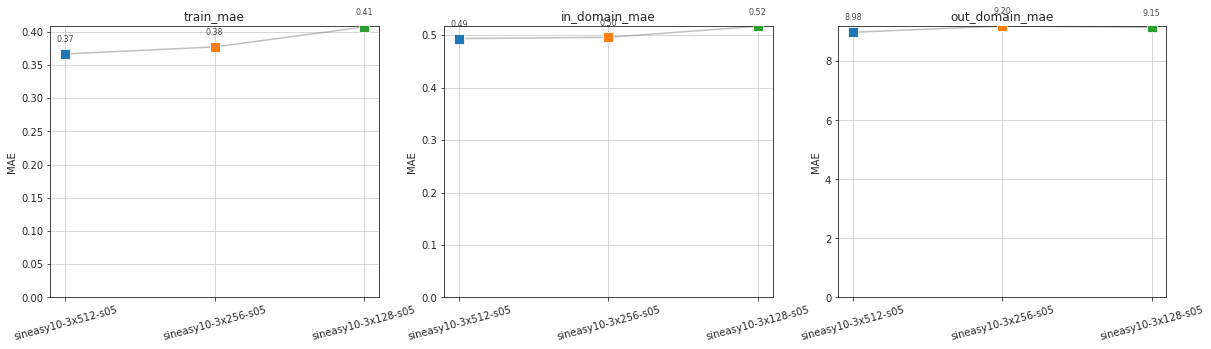

In [12]:
train_rmse = [results[k]["train"]["error"]["rmse"] for k in names]
in_domain_rmse = [results[k]["in_domain"]["error"]["rmse"] for k in names]
out_domain_rmse = [results[k]["out_domain"]["error"]["rmse"] for k in names]

metrics = [("train_rmse", train_rmse), ("in_domain_rmse", in_domain_rmse), ("out_domain_rmse", out_domain_rmse)]



fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    #annotate each point
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("RMSE")
    ax[i].set_ylim(bottom=0.0)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)
    ax[i].grid(False)

plt.show()



train_mae = [results[k]["train"]["error"]["mae"] for k in names]
in_domain_mae = [results[k]["in_domain"]["error"]["mae"] for k in names]
out_domain_mae = [results[k]["out_domain"]["error"]["mae"] for k in names]

metrics = [("train_mae", train_mae), ("in_domain_mae", in_domain_mae), ("out_domain_mae", out_domain_mae)]

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax = ax.flatten()
for i, (n, m) in enumerate(metrics):
    sns.scatterplot(
    x=names, y=m, marker="s", s=100,
    ax=ax[i], c=colors, alpha=1.0, zorder=10)
    sns.lineplot(
    x=names, y=m, ax=ax[i], color="gray", alpha=0.5)
    for x, y in zip(names, m):
        ax[i].annotate(
            f"{y:.2f}",
            xy=(x, y),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.7,
        )
    ax[i].set_title(n)
    ax[i].set_ylabel("MAE")
    ax[i].set_ylim(bottom=0.0)
    #set x labels to be slanted
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(15)

plt.show()

In [13]:
name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


In [14]:
print(data_samples["train_x"].shape)
print(data_samples["train_dist_samples"].shape)
print(posterior_samples[name1]["train"].shape)

(1000, 10)
(1000, 1000)
(1000, 1000)


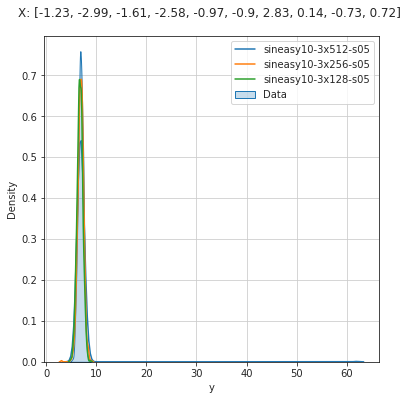

In [15]:

# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = data_samples["train_dist_samples"][:, 1]
pred_train_samples = [posterior_samples[p]["train"][:, 1] for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png")

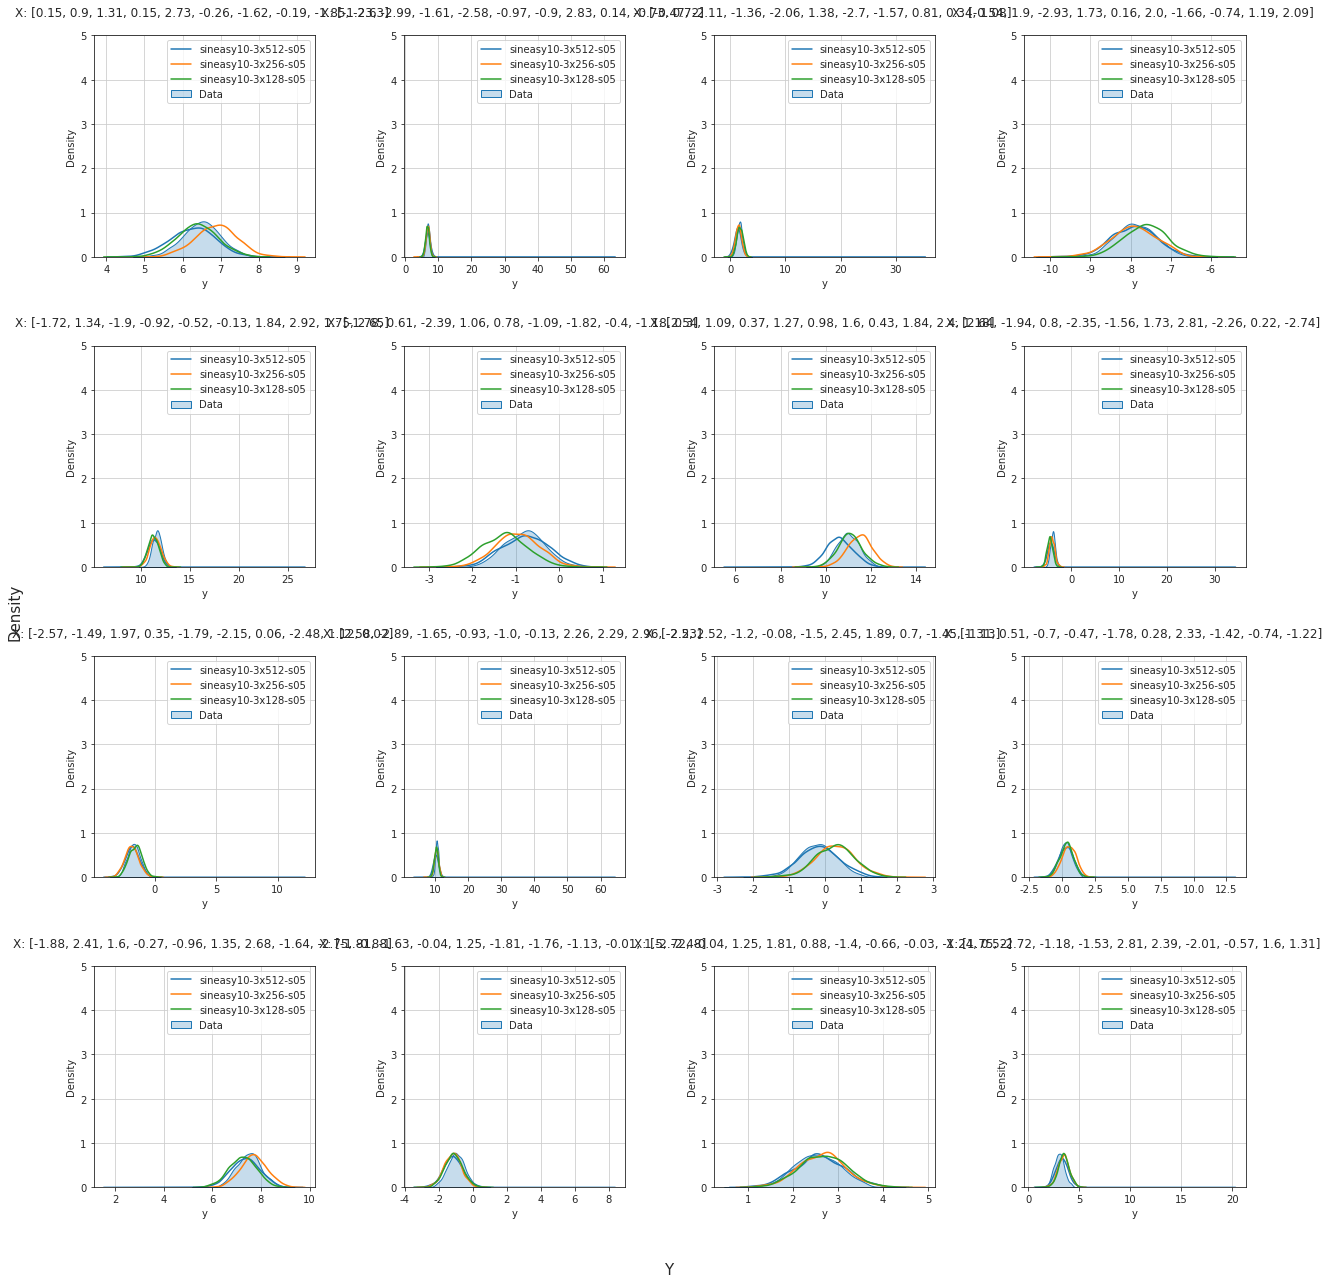

In [16]:

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.show()